In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 15 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 4
cfg['set_id'] = 5

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = GRU_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

GRU_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (gru): GRU(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 0.92705
count = 4, loss = 0.60941
count = 6, loss = 0.41219
count = 8, loss = 0.45682
count = 10, loss = 0.36163
count = 12, loss = 0.36720
count = 14, loss = 0.30199
validation loss: 0.2976748824119568
epoch finished: 1
count = 2, loss = 0.26470
count = 4, loss = 0.30445
count = 6, loss = 0.31559
count = 8, loss = 0.28838
count = 10, loss = 0.22191
count = 12, loss = 0.26987
count = 14, loss = 0.26718
validation loss: 0.23832754790782928
epoch finished: 2
count = 2, loss = 0.25714
count = 4, loss = 0.27719
count = 6, loss = 0.25479
count = 8, loss = 0.26325
count = 10, loss = 0.21698
count = 12, loss = 0.24515
count = 14, loss = 0.24560
validation loss: 0.24265461564064025
epoch finished: 3
count = 2, loss = 0.22515
count = 4, loss = 0.24925
count = 6, loss = 0.23512
count = 8, loss = 0.23610
count = 10, loss = 0.24932
count = 12, loss = 0.28869
count = 14, loss = 0.24347
validation loss: 0.24137441217899322
epoch finished: 4
count = 2, loss = 0.21727
count = 4, loss

In [8]:
np.save('val_loss_gru_set5.npy', val_losses)
np.save('train_loss_gru_set5.npy', train_losses)

In [21]:
model = load_model(LSTM_Score, './models/s4_ba120e9b14.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [9]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.27114412784576414
validation MAE: 0.10444635897874832
QWK Score: 0.8015623031372056


In [10]:
targets

[array([2, 2, 2, 2, 3, 1, 2, 3, 2, 1, 4, 1, 4, 4, 2, 2, 1, 2, 4, 1, 2, 3,
        2, 3, 4, 4, 3, 2, 3, 2, 1, 3, 1, 1, 4, 2, 3, 2, 3, 1, 1, 2, 2, 2,
        4, 4, 3, 2, 2, 4, 1, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 4, 3,
        1, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 4, 2, 3, 3, 2,
        4, 1, 4, 1, 4, 2, 4, 1, 3, 2, 3, 3, 1, 4, 2, 2, 2, 4, 2, 1, 4, 2,
        2, 2, 3, 2, 1, 4, 3, 4, 3, 3]),
 array([3, 3, 3, 1, 3, 3, 2, 4, 4, 3, 3, 2, 2, 1, 3, 2, 4, 4, 4, 2, 2, 4,
        2, 2, 1, 2, 3, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 4, 3, 1, 3, 1, 2,
        3, 2, 3, 2, 4, 1, 3, 2, 2, 2, 3, 2, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3,
        2, 2, 3, 3, 2, 2, 3, 4, 3, 2, 1, 4, 3, 3, 2, 1, 3, 3, 2, 4, 2, 1,
        2, 2, 2, 3, 2, 3, 2, 3, 1, 2, 2, 3, 2, 2, 3, 1, 2, 1, 3, 4, 4, 3,
        3, 4, 3, 4, 4, 4, 4, 2, 3, 2]),
 array([4, 2, 3, 3, 2, 3, 3, 3, 1, 3, 3, 4, 2, 3, 1, 2, 0, 2, 2, 2, 2, 2,
        2, 3, 4, 1, 3, 2, 4, 3, 2, 2, 1, 3, 4, 3, 4, 1, 2, 3, 4, 3, 2, 2,
        4, 1, 2, 3, 4, 2, 2, 2, 

In [11]:
preds

[array([2, 2, 2, 1, 3, 1, 2, 4, 3, 1, 3, 1, 4, 4, 1, 2, 2, 2, 4, 1, 1, 4,
        3, 3, 3, 4, 2, 1, 3, 2, 2, 2, 1, 2, 4, 1, 3, 1, 3, 1, 2, 2, 4, 2,
        3, 4, 3, 2, 1, 4, 1, 4, 2, 4, 3, 3, 2, 3, 3, 3, 2, 2, 4, 2, 3, 2,
        1, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 1, 2, 4, 2, 2, 3, 2,
        3, 1, 4, 2, 3, 2, 3, 1, 2, 2, 3, 2, 1, 3, 2, 1, 2, 4, 3, 2, 3, 2,
        3, 3, 3, 2, 1, 3, 3, 3, 2, 4]),
 array([3, 2, 2, 1, 2, 3, 3, 3, 4, 4, 2, 2, 2, 1, 4, 3, 4, 3, 4, 1, 3, 3,
        2, 2, 1, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 4, 3, 1, 3, 1, 1,
        3, 1, 4, 2, 4, 1, 3, 1, 2, 2, 3, 2, 3, 1, 3, 1, 3, 1, 3, 3, 2, 3,
        2, 1, 3, 3, 2, 2, 2, 3, 3, 2, 1, 4, 4, 3, 3, 1, 2, 3, 2, 4, 2, 1,
        2, 2, 2, 3, 2, 4, 2, 3, 2, 1, 2, 3, 2, 2, 2, 1, 1, 1, 3, 2, 4, 3,
        3, 4, 2, 3, 3, 4, 4, 2, 3, 2]),
 array([3, 3, 3, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 3, 1, 2, 1, 2, 2, 2, 3, 1,
        2, 3, 4, 1, 3, 2, 4, 3, 2, 2, 1, 4, 4, 2, 4, 1, 2, 3, 3, 3, 2, 2,
        4, 2, 2, 3, 3, 2, 2, 3, 

In [12]:
train_losses

[0.9270465075969696,
 0.6094064712524414,
 0.41218987107276917,
 0.45682133734226227,
 0.3616315424442291,
 0.3671969622373581,
 0.3019885867834091,
 0.26470060646533966,
 0.3044450432062149,
 0.3155866116285324,
 0.28837911784648895,
 0.22190823405981064,
 0.26987095177173615,
 0.26718007028102875,
 0.25713540613651276,
 0.2771923840045929,
 0.25479162484407425,
 0.2632504776120186,
 0.21698468923568726,
 0.2451481968164444,
 0.24559896439313889,
 0.22515178471803665,
 0.24924912303686142,
 0.23511581867933273,
 0.23610176146030426,
 0.24932322651147842,
 0.28869135677814484,
 0.24346598237752914,
 0.21726517379283905,
 0.22326340526342392,
 0.21847986429929733,
 0.22700180113315582,
 0.21999158710241318,
 0.2923514023423195,
 0.2320580706000328,
 0.21894724667072296,
 0.204591304063797,
 0.250289186835289,
 0.2671421319246292,
 0.23953405767679214,
 0.21411771327257156,
 0.20824193209409714,
 0.23176834732294083,
 0.25889504700899124,
 0.20481134206056595,
 0.20377158373594284,
 0.30

In [13]:
val_losses

[0.2976748824119568,
 0.23832754790782928,
 0.24265461564064025,
 0.24137441217899322,
 0.24315072894096373,
 0.22930088639259338,
 0.24395695626735686,
 0.273736509680748,
 0.25051693320274354,
 0.23929619491100312,
 0.23978034555912017,
 0.23448716700077057,
 0.26102291643619535,
 0.26034952998161315,
 0.2858524888753891]

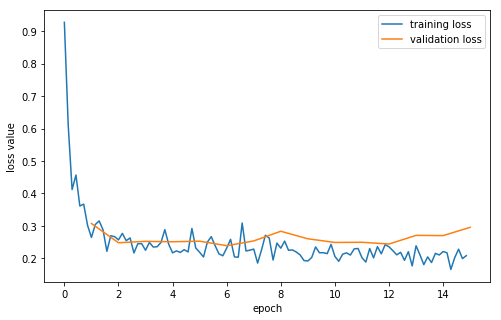

In [15]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()